In [2]:
import numpy as np
import numpy.ma as ma
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, LeavePOut, validation_curve, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import warnings
sns.set()
warnings.filterwarnings("ignore")

In [3]:
data0 = pd.read_csv('/Users/ceciliachen/Desktop/NYU/1001/project/movieReplicationSet.csv')

In [3]:
data0.head()

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,When watching a movie I cheer or shout or talk or curse at the screen,When watching a movie I feel like the things on the screen are happening to me,As a movie unfolds I start to have problems keeping track of events that happened earlier,"The emotions on the screen ""rub off"" on me - for instance if something sad is happening I get sad or if something frightening is happening I get scared",When watching a movie I get completely immersed in the alternative reality of the film,Movies change my position on social economic or political issues,When watching movies things get so intense that I have to stop watching,Gender identity (1 = female; 2 = male; 3 = self-described),Are you an only child? (1: Yes; 0: No; -1: Did not respond),Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)
0,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,1.0,6.0,2.0,5.0,5.0,5.0,1.0,1.0,0,1
1,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,1.0,1.0,6.0,5.0,3.0,2.0,1.0,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,4.0,3.0,5.0,5.0,4.0,4.0,1.0,1,0
3,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,4.0,...,3.0,1.0,1.0,4.0,5.0,3.0,1.0,1.0,0,1
4,NaN,NaN,3.5,NaN,0.5,NaN,0.5,1.0,NaN,0.0,...,2.0,3.0,2.0,5.0,6.0,4.0,4.0,1.0,1,1


In [4]:
movie_columns = data0.iloc[:, :400]
remaining_columns = data0.iloc[:, 400:]

# Applying the logic separately to each part
movie_filled = movie_columns.apply(lambda x: x.fillna((x.mean() + movie_columns.mean(axis=1)) / 2))
remaining_filled = remaining_columns.apply(lambda x: x.fillna((x.mean() + remaining_columns.mean(axis=1)) / 2))

# Concatenating the two parts back together
data = pd.concat([movie_filled, remaining_filled], axis=1)

Data handling suggestions: To answer the questions properly, you’ll have to do some kind of imputation of
missing ratings (nans). Given the scope of this class, replacing them with a blend (50/50 is ok) of the
arithmetic mean of each column and each row might be most suitable. Don’t get used to this – there are
many problems with this approach. But for now, this is ok - you’ll learn more sophisticated methods later.
But let’s say that the rating of user 350 for movie 200 is missing and that the average rating of this user for
other movies is 4 and the average rating (by other users) for this movie is 3, the to-be-imputed rating would
be 3.5, using this method.

In [5]:
nan_counts_per_row = data.iloc[:, :400].isnull().sum(axis=1)

# Iterating over the Series
for index, nan_count in nan_counts_per_row.iteritems():
    if nan_count != 0:
        print(f"Row {index} has {nan_count} NaN values.")


Row 896 has 400 NaN values.


In [6]:
nan_counts_per_row2 = data.iloc[:, 400:].isnull().sum(axis=1)

# Iterating over the Series
for index, nan_count in nan_counts_per_row.iteritems():
    if nan_count != 0:
        print(f"Row {index} has {nan_count} NaN values.")

Row 896 has 400 NaN values.


In [7]:
data.iloc[896, :400] = data.iloc[896, :400].fillna(data.mean())
data.iloc[896, 400:] = data.iloc[896, 400:].fillna(data.mean())

In [8]:
df = data.iloc[:, :400]
df

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,X-Men 2 (2003),The Usual Suspects (1995),The Mask (1994),Jaws (1975),Harry Potter and the Chamber of Secrets (2002),Patton (1970),Anaconda (1997),Twister (1996),MacArthur (1977),Look Who's Talking (1989)
0,2.447086,2.381992,4.000000,2.725235,3.000000,2.670257,2.554121,2.821232,2.619604,2.827211,...,2.828460,2.921947,2.650951,4.000000,0.500000,2.510773,2.519156,2.572578,2.428806,2.540410
1,2.439294,2.374200,1.500000,2.717443,2.752945,2.662464,2.546329,2.813440,2.611812,2.819419,...,2.820668,2.914154,2.643159,2.673112,4.000000,2.502981,2.511364,2.564786,2.421013,2.532618
2,2.733065,2.667971,3.234118,3.011214,3.046716,2.956236,2.840100,3.107211,2.905583,3.113190,...,3.114439,3.207926,2.936930,2.966883,3.500000,2.796752,2.805135,2.858557,2.714784,2.826389
3,2.282975,2.217880,2.000000,2.561123,3.000000,2.506145,2.390009,2.657120,2.455492,4.000000,...,2.664348,3.000000,2.486840,2.516793,2.500000,2.346661,2.355044,2.408466,2.264694,2.376299
4,2.209132,2.144038,3.500000,2.487281,0.500000,2.432303,0.500000,1.000000,2.381650,0.000000,...,2.500000,2.683993,3.000000,2.442950,2.769704,2.272819,2.281202,1.500000,2.190852,2.302456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,2.675658,2.610563,3.176711,2.953806,3.500000,2.898828,2.782692,3.049803,2.848175,3.055782,...,3.057031,3.150518,2.879523,2.909476,4.000000,2.739344,2.747727,2.801149,2.657377,2.768981
1093,3.000000,4.000000,3.413546,3.190641,4.000000,4.000000,2.500000,3.286638,3.500000,3.500000,...,4.000000,3.387353,4.000000,3.500000,3.500000,4.000000,3.500000,4.000000,4.000000,4.000000
1094,2.641923,2.576828,3.142976,2.920071,2.955574,2.865093,2.748957,3.500000,2.814440,3.022047,...,3.023296,3.116783,2.845788,2.875741,4.000000,2.705609,2.713992,2.767414,2.623642,2.735247
1095,2.770970,2.705876,3.272023,3.049119,3.084621,2.994141,2.878005,3.145116,2.943488,3.151095,...,3.152344,3.245831,2.974835,3.004788,2.500000,2.834657,2.843040,2.896462,2.752690,2.864294


For each of the 400 movies, use a simple linear regression model to predict the ratings. Use the ratings
of the *other* 399 movies in the dataset to predict the ratings of each movie (that means you’ll have
to build 399 models for each of the 400 movies).
For each of the 400 movies, find the movie that predicts ratings the best. Then report the average COD of those 400 simple linear regression models.
Please include a histogram of these 400 COD values and a table with the 10 movies that are most easily predicted from the ratings of a single other movie and the 10 movies that are hardest to predict from the ratings of a single other movie (and their associated COD values, as well as which movie ratings are the best predictor, so this table should have 3 columns). 

In [9]:
best_predictors = {}
average_cod_values = {}

# Iterate over each movie to create models
for movie in df.columns:
    other_movies = df.drop(columns=[movie])
    cod_list = []
    best_cod = -float('inf')
    best_predictor = None

    for predictor in other_movies.columns:
        # Prepare the data
        X = other_movies[predictor].values.reshape(-1, 1)
        y = df[movie].values

        # Create and fit the model
        reg = LinearRegression().fit(X, y)
        y_hat = reg.predict(X)

        # Calculate COD
        r2 = r2_score(y, y_hat)
        cod_list.append(r2)

        # Check if this is the best predictor so far
        if r2 > best_cod:
            best_cod = r2
            best_predictor = predictor

    # Calculate the average COD for this movie
    average_cod = np.mean(cod_list)
    average_cod_values[movie] = average_cod

    # Store the best predictor and its COD
    best_predictors[movie] = (best_predictor, best_cod)

In [10]:
best_predictors

{'The Life of David Gale (2003)': ('The King of Marvin Gardens (1972)',
  0.5675329673680642),
 'Wing Commander (1999)': ('From Hell (2001)', 0.5606275642181673),
 'Django Unchained (2012)': ('The Life of David Gale (2003)',
  0.23233530678010406),
 'Alien (1979)': ('Aliens (1986)', 0.32954793641177993),
 'Indiana Jones and the Last Crusade (1989)': ('Indiana Jones and the Temple of Doom (1984)',
  0.3744782737500618),
 'Snatch (2000)': ('Slackers (2002)', 0.45983684517772305),
 'Rambo: First Blood Part II (1985)': ('Pieces of April (2003)',
  0.28911668225139187),
 'Fargo (1996)': ('Brazil (1985)', 0.28672798290158985),
 'Let the Right One In (2008)': ('Slackers (2002)', 0.440634409724456),
 'Black Swan (2010)': ('Sorority Boys (2002)', 0.11708033979272658),
 'King Kong (1976)': ('Unforgiven (1992)', 0.21748992290395797),
 'The Machinist (2004)': ('Escape from LA (1996)', 0.428765958035613),
 'A Nightmare on Elm Street (1984)': ('Tropic of Cancer (1970)',
  0.21174664733151294),
 'Bra

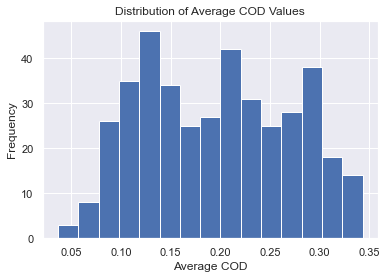

In [11]:
average_cod_list = list(average_cod_values.values())

# Plotting the distribution of average COD values
plt.hist(average_cod_list, bins=15)
plt.title('Distribution of Average COD Values')
plt.xlabel('Average COD')
plt.ylabel('Frequency')
plt.show()


In [12]:
# Convert the results to a DataFrame for easier manipulation
results_df = pd.DataFrame({
    'Movie': best_predictors.keys(),
    'Best Predictor': [best[0] for best in best_predictors.values()],
    'COD': [best[1] for best in best_predictors.values()],
    'Average COD': average_cod_values.values()
})

# Sort the DataFrame by Average COD
sorted_df = results_df.sort_values(by='Average COD', ascending=False)

# Select the top 10 and bottom 10 movies
top_10 = sorted_df.head(10)
bottom_10 = sorted_df.tail(10)

predictmovies20 = pd.concat([top_10, bottom_10], keys=['10 Easiest', '10 Hardest']).drop(columns=['Average COD'])
justmovies = pd.concat([top_10, bottom_10])


In [1]:
top_10

NameError: name 'top_10' is not defined

In [13]:
predictmovies20

Movie  \
10 Easiest 116                              Escape from LA (1996)   
           109                                  Sexy Beast (2000)   
           377                                 The Lookout (2007)   
           203                             Erik the Viking (1989)   
           298                                Crimson Tide (1995)   
           240                                  The Bandit (1996)   
           395                                      Patton (1970)   
           287                          The Straight Story (1999)   
           363                           Miller's Crossing (1990)   
           309                               Heavy Traffic (1973)   
10 Hardest 87                                        Shrek (2001)   
           75   Pirates of the Caribbean: Dead Man's Chest (2006)   
           55                                     Clueless (1995)   
           186                                The Avengers (2012)   
           57                                      Shrek 2 (2004)   
           190                      The Cabin in the Woods (2012)   
           9                                    Black Swan (2010)   
           95                                 Interstellar (2014)   
           84                                The Conjuring (2013)   
           80                                       Avatar (2009)   

                                                 Best Predictor       COD  
10 Easiest 116                                Sexy Beast (2000)  0.649610  
           109                             The Silencers (1966)  0.659436  
           377                                    Patton (1970)  0.713554  
           203                                      I.Q. (1994)  0.731507  
           298                        The Straight Story (1999)  0.678454  
           240                           Best Laid Plans (1999)  0.711222  
           395                               The Lookout (2007)  0.713554  
           287                                     Congo (1995)  0.700569  
           363                               The Lookout (2007)  0.656781  
           309                                       Ran (1985)  0.692734  
10 Hardest 87                                    Shrek 2 (2004)  0.451027  
           75   Pirates of the Caribbean: At World's End (2007)  0.367212  
           55                             Escape from LA (1996)  0.141426  
           186                Captain America: Civil War (2016)  0.272223  
           57                                      Shrek (2001)  0.451027  
           190                             The Evil Dead (1981)  0.143887  
           9                               Sorority Boys (2002)  0.117080  
           95                                     Torque (2004)  0.111343  
           84                               The Exorcist (1973)  0.198474  
           80                                   Bad Boys (1995)  0.079485

For the 10 movies that are best and least well predicted from the ratings of a single other movie (so
20 in total), build multiple regression models that include gender identity (column 475), sibship status
(column 476) and social viewing preferences (column 477) as additional predictors (in addition to the
best predicting movie from question 1). Comment on how R^2 has changed relative to the answers
in question 1. Please include a figure with a scatterplot where the old COD (for the simple linear
regression models from the previous question) is on the x-axis and the new R^2 (for the new multiple
regression models) is on the y-axis.

In [14]:
data0.iloc[:, 474:477].isnull().sum(axis = 0)

Gender identity (1 = female; 2 = male; 3 = self-described)            24
Are you an only child? (1: Yes; 0: No; -1: Did not respond)            0
Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)     0
dtype: int64

In [15]:
# Placeholder lists for the old COD and the new R² values
old_cod = predictmovies20['COD'].tolist()
new_r2 = []

# Iterate through the DataFrame rows to build the multiple regression models
for movie in justmovies['Movie']:
    complete_ratings = data[movie].values.reshape(-1,1)
    best_predictor = justmovies.loc[justmovies['Movie'] == movie, 'Best Predictor']
    # Extract the ratings for the best predictor movie
    best_predictor_ratings = data[best_predictor].values.reshape(-1,1)
    gender_identity = data0.iloc[:, 474].fillna(-1).values.reshape(-1,1)
    sibship_status = data.iloc[:, 475].values.reshape(-1,1)
    social_viewing_preferences = data.iloc[:, 476].values.reshape(-1,1)

    X = np.concatenate((best_predictor_ratings, gender_identity, sibship_status, social_viewing_preferences), axis=1)
    y = complete_ratings

    # Fit the multiple regression model
    model = LinearRegression().fit(X, y)

    # Predict the target movie ratings
    y_hat = model.predict(X)
    r2 = r2_score(y, y_hat)

    # Calculate the new R² value and add it to the list
    new_r2.append(r2)


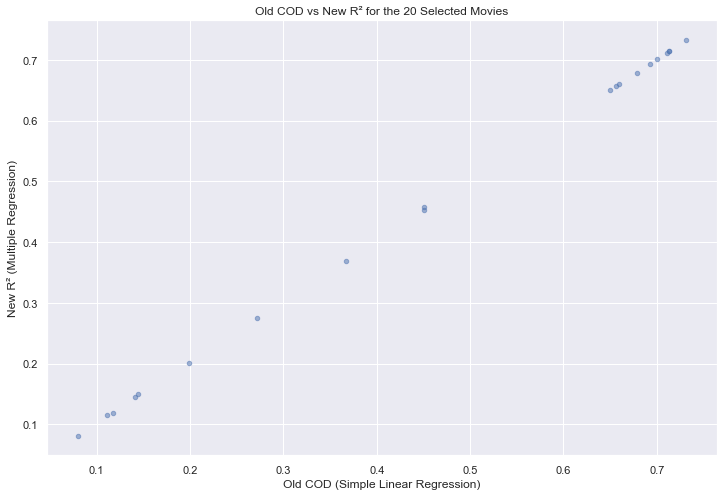

In [16]:
plt.figure(figsize=(12, 8))
plt.scatter(old_cod, new_r2, alpha = 0.5, s=20)
plt.xlabel('Old COD (Simple Linear Regression)')
plt.ylabel('New R² (Multiple Regression)')
plt.title('Old COD vs New R² for the 20 Selected Movies')
plt.grid(True)
plt.show()

In [17]:
pd.DataFrame({'old r2': old_cod, 'new r2': new_r2})

,old r2,new r2
0,0.649610,0.650248
1,0.659436,0.661056
2,0.713554,0.715080
3,0.731507,0.732332
4,0.678454,0.678762
5,0.711222,0.711735
6,0.713554,0.714680
7,0.700569,0.700932
8,0.656781,0.657228
9,0.692734,0.692935


3)Pick 30 movies in the middle of the COD range, as identified by question 1 (that were not used in
question 2). Now build a regularized regression model with the ratings from 10 other movies (picked
randomly, or deliberately by you) as an input. Please use ridge regression, and make sure to do
suitable hyperparameter tuning. Also make sure to report the RMSE for each of these 30 movies in a
table, after doing an 80/20 train/test split. Comment on the hyperparameters you use and betas you
find by doing so

In [33]:
# Picked the middle 30 movies
middle_range_movies = sorted_df[200-15:200+15]

# Extract just the movie names from the middle range
middle_range_movie_names = middle_range_movies['Movie'].tolist()

# Select 10 other movies to use as predictors
predictor_movie_names = df.columns.difference(middle_range_movie_names).tolist()[:10]
predictor_movie_names

['10 Things I Hate About You (1999)',
 '10000 BC (2008)',
 '13 Going on 30 (2004)',
 '21 Grams (2003)',
 '25th Hour (2002)',
 '28 Days Later (2002)',
 '3000 Miles to Graceland (2001)',
 '8 Mile (2002)',
 'A Beautiful Mind (2001)',
 "A Bug's Life (1998)"]

In [47]:
# Define the Polynomial Ridge Regression function
def PolynomialRidgeRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

# Define a range of alphas for Ridge
alphas = np.logspace(-2, 1, 100)

# Create the grid
param_grid = {'ridge__alpha': alphas}

# Initialize a DataFrame to store RMSE values
rmse_results = []

# Loop over each of the 30 selected middle-range movies
for movie in middle_range_movie_names:
    # Prepare the feature matrix X and target vector y
    X = df[predictor_movie_names].values
    y = df[movie].values

    # Perform an 80/20 train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Grid Search for Hyperparameter Tuning
    grid_search = GridSearchCV(
        PolynomialRidgeRegression(), 
        param_grid=param_grid, 
        scoring='neg_mean_squared_error',
        cv=5
    )
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Store the results
    rmse_results.append({
        'Movie': movie, 
        'RMSE': rmse, 
        'Alpha': grid_search.best_params_['ridge__alpha'], 
        'Weights': best_model.named_steps['ridge'].coef_
    })

# Create a DataFrame with the results
rmse_df = pd.DataFrame(rmse_results)

# Sort the DataFrame by RMSE and reset index
rmse_df_sorted = rmse_df.sort_values(by='RMSE').reset_index(drop=True)

# Display the DataFrame
rmse_df_sorted

,Movie,RMSE,Alpha,Weights
0,Crossroads (2002),0.286837,10.000000,"[0.0, -0.0030763304163559614, 0.15701682415614..."
1,The Green Mile (1999),0.294768,10.000000,"[0.0, 0.11262143143373228, 0.10726147364756657..."
2,You're Next (2011),0.327881,10.000000,"[0.0, 0.11362057765631538, 0.21998654253825886..."
3,Man on Fire (2004),0.334144,10.000000,"[0.0, 0.05076837328714767, 0.01328292524465111..."
4,Aliens (1986),0.341551,10.000000,"[0.0, 0.10648715387749506, 0.17729552307535276..."
5,Gone in Sixty Seconds (2000),0.371411,10.000000,"[0.0, -0.03757677271748244, -0.104401852496877..."
6,Big Daddy (1999),0.373071,10.000000,"[0.0, 0.009739445675856674, 0.0758916134711297..."
7,Child's Play (1988),0.381841,10.000000,"[0.0, 0.15800126465555137, 0.0855346197751011,..."
8,Full Metal Jacket (1987),0.385251,10.000000,"[0.0, 0.1198217470263509, 0.060524478303064566..."
9,The Thing (1982),0.386915,10.000000,"[0.0, 0.08100736122941841, -0.0613085350609957..."


4)Repeat question 3) with LASSO regression. Again, make sure to comment on the hyperparameters
you use and betas you find by doing so. 

In [43]:
# Define the Polynomial Lasso Regression function
def PolynomialLassoRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Lasso(**kwargs))

# Define a range of alphas for Lasso
alphas = np.logspace(-10, 2, 100)

# Create the grid
param_grid = {'lasso__alpha': alphas}

# Initialize a DataFrame to store RMSE values
rmse_results = []

# Loop over each of the 30 selected middle-range movies
for movie in middle_range_movie_names:
    # Prepare the feature matrix X and target vector y
    X = df[predictor_movie_names].values
    y = df[movie].values

    # Perform an 80/20 train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Grid Search for Hyperparameter Tuning
    lasso_grid = GridSearchCV(
        PolynomialLassoRegression(), 
        param_grid=param_grid, 
        scoring='neg_mean_squared_error',
        cv=5
    )
    lasso_grid.fit(X_train, y_train)

    # Best model
    best_model = lasso_grid.best_estimator_
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Store the results
    rmse_results.append({
        'Movie': movie, 
        'RMSE': rmse, 
        'Alpha': lasso_grid.best_params_['lasso__alpha'], 
        'Weights': best_model.named_steps['lasso'].coef_
    })


# Create a DataFrame with the results
rmse_df = pd.DataFrame(rmse_results)
rmse_df_sort = rmse_df.sort_values(by = 'RMSE').reset_index(drop = True)
# Display the DataFrame
rmse_df_sort

,Movie,RMSE,Alpha,Weights
0,The Green Mile (1999),0.302870,0.013219,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Man on Fire (2004),0.303695,0.070548,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Crossroads (2002),0.314025,0.030539,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Gone in Sixty Seconds (2000),0.317967,0.030539,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Blues Brothers 2000 (1998),0.338477,0.010000,"[0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,Aliens (1986),0.339159,0.005722,"[0.0, 0.0, 0.1968913988380116, 0.0144960205193..."
6,You're Next (2011),0.357770,0.017475,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Big Daddy (1999),0.358436,0.023101,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0,..."
8,The Mist (2007),0.371687,0.013219,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Child's Play (1988),0.374458,0.023101,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


5) Compute the average movie enjoyment for each user (using only real, non-imputed data). Use these
averages as the predictor variable X in a logistic regression model. Sort the movies order of increasing
rating (also using only real, non-imputed data). Now pick the 4 movies in the middle of the score range
as your target movie. For each of them, do a media split (now using the imputed data) of ratings to
code movies above the median rating with the Y label 1 (= enjoyed) and movies below the median
with the label 0 (= not enjoyed). For each of these movies, build a logistic regression model (using X
to predict Y), show figures with the outcomes and report the betas as well as the AUC values.
Comment on the quality of your models. Make sure to use cross-validation methods to avoid
overfitting.

In [50]:
# Compute the average for each user using real, non-imputed data
avg_enjoyment = data0.iloc[:, :400].mean(axis=1)
X = avg_enjoyment.fillna(avg_enjoyment.mean()).values.reshape(-1, 1)  # Predictor variable X
X

array([[2.74285714],
       [2.72727273],
       [3.31481481],
       ...,
       [3.13253012],
       [3.390625  ],
       [2.87387387]])

In [51]:
# Sort movies based on their average rating using non-imputed data
movie_avg_ratings = data0.iloc[:, :400].mean().sort_values()
# Pick 4 middle movies
middle_movies = movie_avg_ratings.iloc[198 : 202].index
middle_movies

Index(['Fahrenheit 9/11 (2004)', 'Happy Gilmore (1996)',
       'Diamonds are Forever (1971)', 'Scream (1996)'],
      dtype='object')

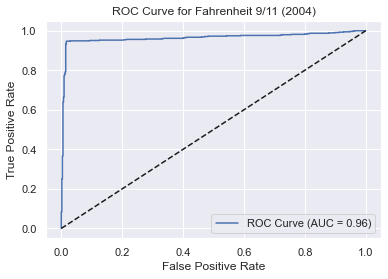

Movie: Fahrenheit 9/11 (2004)
Average AUC: 0.96
Model Coefficients: [7.39636383]




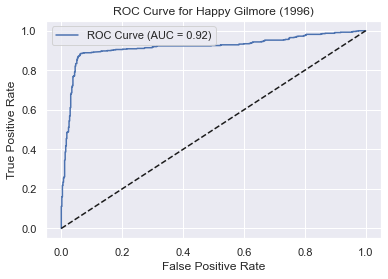

Movie: Happy Gilmore (1996)
Average AUC: 0.92
Model Coefficients: [5.201532]




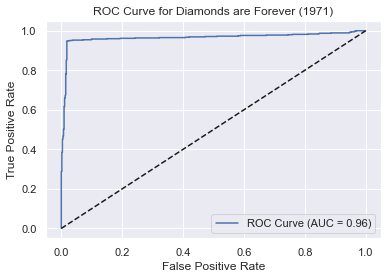

Movie: Diamonds are Forever (1971)
Average AUC: 0.96
Model Coefficients: [7.32554404]




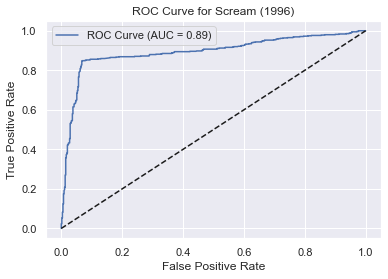

Movie: Scream (1996)
Average AUC: 0.89
Model Coefficients: [4.41567957]




In [52]:
# Loop over each of the 4 middle movies
for movie in middle_movies:
    Y = df[movie].values
    median_rating = np.median(Y) 
    Y_binary = (Y > median_rating).astype(int)  # Binary classification
    model = LogisticRegression()
    auc_scores = cross_val_score(model, X, Y_binary, cv=5, scoring='roc_auc')
    
    # Fit the model on the entire dataset (for plotting ROC curve)
    model.fit(X, Y_binary)

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(Y_binary, model.predict_proba(X)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {np.mean(auc_scores):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {movie}')
    plt.legend(loc='best')
    plt.show()

    # Print model information
    print(f"Movie: {movie}")
    print(f"Average AUC: {np.mean(auc_scores):.2f}")
    print(f"Model Coefficients: {model.coef_[0]}")
    print("\n")

Extra Credit: Use machine learning methods of your choice to tell us something interesting and true about
the movies in this dataset that is not already covered by the questions above [for an additional 5% of the
grade score].

In [53]:
y_avatar = data0.loc[:,['Avatar (2009)']].fillna(0)
y_titanic = data0.loc[:,['Titanic (1997)']].fillna(0)

y = data0.loc[:,['Avatar (2009)','Titanic (1997)' ]].fillna(0)
movie_name = ['Avatar (2009)','Titanic (1997)' ]

In [54]:
X = data.loc[:, [
    'is outgoing/sociable', 
    'Is ingenious/a deep thinker', 
    'Is emotionally stable/not easily upset', 
    'Makes plans and follows through with them', 
    'Has an assertive personality'
]].fillna(0)

personality = [
    'is outgoing/sociable', 
    'Is ingenious/a deep thinker', 
    'Is emotionally stable/not easily upset', 
    'Makes plans and follows through with them', 
    'Has an assertive personality'
]

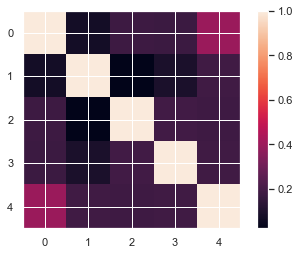

In [55]:
r = np.corrcoef(X,rowvar=False)
plt.imshow(r) 
plt.colorbar()
plt.show()

In [56]:
Xa_train, Xa_test, ya_train, ya_test = train_test_split(X, y_avatar, test_size=0.2, random_state = 42)

Xt_train, Xt_test, yt_train, yt_test = train_test_split(X, y_titanic, test_size=0.2, random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [58]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  1.671


In [59]:
rf_titanic = RandomForestRegressor(n_estimators=100, random_state=42)
rf_avatar = RandomForestRegressor(n_estimators=100, random_state=42)
rf_all = RandomForestRegressor(n_estimators=100, random_state=42)


# Train the models
rf_titanic.fit(Xt_train, yt_train)
rf_avatar.fit(Xa_train, ya_train)


# Feature importance for Titanic movie
titanic_feature_importance = rf_titanic.feature_importances_
print("Feature Importance for Titanic movie:")
for i, importance in enumerate(titanic_feature_importance):
    print(f"{personality[i]}: {importance}")

# Feature importance for Avatar movie
avatar_feature_importance = rf_avatar.feature_importances_
print("\nFeature Importance for Avatar movie:")
for i, importance in enumerate(avatar_feature_importance):
    print(f"{personality[i]}: {importance}")

Feature Importance for Titanic movie:
is outgoing/sociable: 0.16435382503746698
Is ingenious/a deep thinker: 0.1914253046250887
Is emotionally stable/not easily upset: 0.22226184149780065
Makes plans and follows through with them: 0.2191688644394475
Has an assertive personality: 0.2027901644001962

Feature Importance for Avatar movie:
is outgoing/sociable: 0.21801450619537538
Is ingenious/a deep thinker: 0.18084326892304253
Is emotionally stable/not easily upset: 0.22068990200094812
Makes plans and follows through with them: 0.18470178089732456
Has an assertive personality: 0.19575054198330943


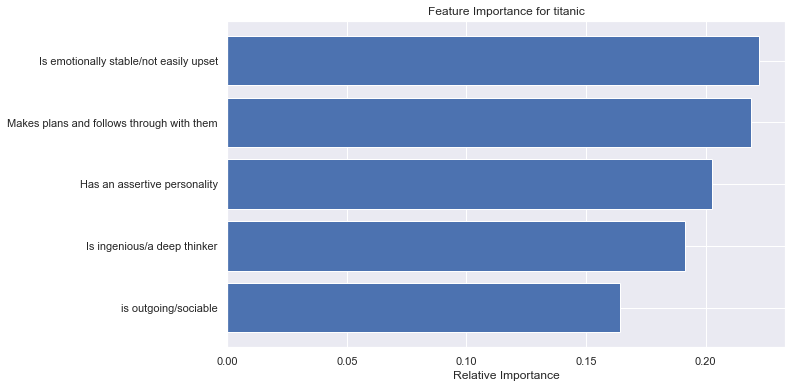

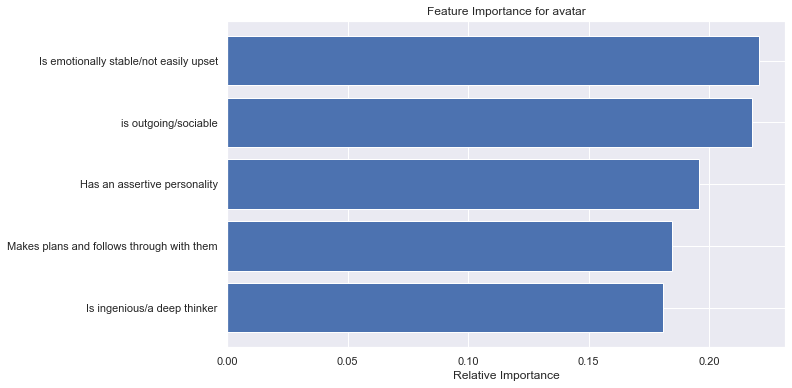

In [60]:
importance = rf.feature_importances_

# Function to plot feature importance
def plot_rf_feature_importance(importances, features, title):
    indices = np.argsort(importances)
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

plot_rf_feature_importance(titanic_feature_importance, personality, 'Feature Importance for titanic')
plot_rf_feature_importance(avatar_feature_importance, personality, 'Feature Importance for avatar')